In [1]:
# Notebook Imports
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import string
from collections import defaultdict
from sklearn.metrics import r2_score
import statsmodels.api as sm
%matplotlib inline

conn = psycopg2.connect(dbname="illinois_gambling")

def query(query):
    return pd.read_sql(query, conn)

## Introduction

Video gambling was legalized by the state of Illinois in 2009, with the first machines activated in September of 2012. Since then the number of towns that have installed video gambling machines has increased every year. 

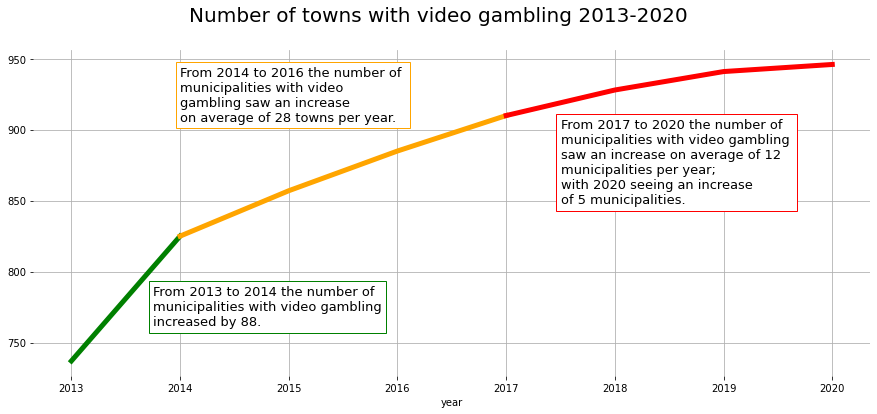

In [6]:
q = '''SELECT DISTINCT CAST(date_part('year', video_gambling.date) AS INT) as year, 
              count(DISTINCT municipality.name) as num_of_towns
       FROM municipality
       INNER JOIN video_gambling
       ON municipality.name = video_gambling.municipality
       GROUP BY date_part('year', video_gambling.date);'''

query_results = query(q).set_index('year')
fig, ax = plt.subplots()
query_results.loc[:2014].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='green')
query_results.loc[2014:2017].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='orange')
query_results.loc[2017:].num_of_towns.plot(ax=ax, figsize=(15,6), linewidth=5, linestyle='-', c='red')
# axes[0].set_yticks(query_results.num_of_towns)
fig.suptitle('Number of towns with video gambling 2013-2020', fontsize=20)
ax.grid()

ax.set_frame_on(False)

first_annotation = ax.text(2013.75, 762, 
f'''From 2013 to 2014 the number of\nmunicipalities \
with video gambling\nincreased by\
 {int(query_results.loc[[2013,2014]].num_of_towns.diff().iloc[1])}.''', dict(size=13))
first_annotation.set_bbox(dict(facecolor='white', edgecolor='green'))

second_annotation = ax.text(2014, 906, f'''\
From 2014 to 2016 the number of 
municipalities with video 
gambling saw an increase\non average of \
{int(round(query_results.loc[2014:2017].num_of_towns.diff().mean()))} \
towns per year.''', dict(size=13))
second_annotation.set_bbox(dict(facecolor='white', edgecolor='orange'))

third_annotation = ax.text(2017.5, 848, f'''\
From 2017 to 2020 the number of
municipalities with video gambling 
saw an increase on average of \
{int(round(query_results.loc[2017:].num_of_towns.diff().mean()))} 
municipalities per year; 
with 2020 seeing an increase 
of {int(round(query_results.loc[2017:].num_of_towns.diff().loc[2020]))} municipalities.''', dict(size=13))
third_annotation.set_bbox(dict(facecolor='white', edgecolor='red'))


## Outline

- Video gambling growth
    - ~~Increase of towns~~
    - Increase of gambling devices
    - Increase of amount played
    - Change in revenue for state and local governments
    - Amount returns to owner
    
- Casino growth
    - Increase in casinos
    - Increase in adjusted gross receipt
    - Increase in local and state shares
    
- Breakdown of tax rates
    - Visualization of the difference in the distribution between the vg and casino tax rates
    
- Analysis of the correlation between amount played and AGR.
    
- Analysis of casino loss 
    - Description of the data that has been collected
    - Description of how municipalities were clustered according to the nearest casino
    - Analysis of the statistical likelyhood of having a tax rate > 30%
        - Check the year frequency within the population of tax rates that fell above 30%
    - Modeling the data with MLM
        - Baseline: AGR ~ amount_played_centered
        - Bring in industry variables
        - Bring in demographic variables

In [83]:
q = '''SELECT DISTINCT municipality
        FROM casino;'''

towns_with_casinos = query(q)

q = '''SELECT DISTINCT town.name
        FROM municipality town
        LEFT JOIN casino ON casino.municipality = town.name
        WHERE casino.municipality IS NULL'''
towns_without_casinos = query(q)

q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + '"' +  lookup['variable'] + '"').to_list()

q = f'''SELECT {", ".join(demographic_variables)},
              video.terminal_count,
              video.date,
              video.state_share as video_state_share,
              video.municipality_share as video_local_share,
              video.amount_played,
              town.name,
              town.nearest_casino,
              casino.adjusted_gross_receipt,
              casino.state_share as casino_state_share,
              casino.local_share as casino_local_share
      FROM demographics demo
      JOIN municipality town
          ON demo.municipality = town.name
          AND demo.geo_id = town.geo_id
     JOIN casino
          ON casino.address = town.nearest_casino
     JOIN video_gambling video
          ON video.municipality = town.name
     WHERE date_part('year', video.date) = demo.year
     AND casino.date = video.date
     ORDER BY date;'''


q = """SELECT terminal_count, 
              amount_played,
              town.name
              nearest_casino,
              video_state_share,
              video_local_share,
              casino.state_share AS casino_state_share,
              casino.local_share AS casino_local_share,
              date,
              adjusted_gross_receipt,
              FROM (
                      SELECT SUM(terminal_count), SUM(amount_played,)
                             SUM(municipality_share) AS video_local_share,
                             SUM(state_share) AS video_state_share,
                             name,
                             FROM video_gambling
                             GROUP BY DATE_PART('year', 'date'), 
                                      DATE_PART('month', 'date'), 
                                      town.nearest_casino)
                             INNER JOIN municipality town
                             ON video_gamling.municipality = municipality.name ) subquery
            INNER JOIN casino
            ON subquery.name = casino.municipality;
              """

df = query(q)

In [ ]:
q = """SELECT terminal_count, 
              amount_played,
              town.name
              nearest_casino,
              video_state_share,
              video_local_share,
              casino.state_share AS casino_state_share,
              casino.local_share AS casino_local_share,
              date,
              adjusted_gross_receipt
              FROM (
                      SELECT SUM(terminal_count), SUM(amount_played),
                             SUM(municipality_share) AS video_local_share,
                             SUM(state_share) AS video_state_share
                             FROM video_gambling
                             INNER JOIN municipality town
                             ON video_gambling.municipality = town.name
                             GROUP BY DATE_PART('year', video_gambling.date), 
                                      DATE_PART('month', video_gambling.date), 
                                      town.nearest_casino) AS subquery
            INNER JOIN casino
            ON subquery.name = casino.municipality;
              """



"""SELECT SUM(amount_played),
          SUM(terminal_count),
          SUM(municipality_share) AS video_local

In [ ]:
q = '''SELECT * from demographics_lookup'''

lookup = query(q)

demographic_variables = ('demo.' + '"' +  lookup['variable'] + '"').to_list()

# q = f"""SELECT town.nearest_casino,

#               CAST(CAST(DATE_PART('YEAR',casino.date) AS INTEGER) AS TEXT) AS year,
              
#               SUM(casino.adjusted_gross_receipt) AS agr,
#               SUM(video.amount_played) AS amount_played,
#               SUM(terminal_count) AS terminal_count,
#               SUM(video.municipality_share) AS video_local_share,
#               SUM(video.state_share) as video_state_share,
#               SUM(casino.local_share) as casino_local_share,
#               SUM(casino.state_share) as casino_state_share,
#               {", ".join(f"SUM({demo} ) AS {demo.replace('demo.', '')}" for demo in demographic_variables)}
#               FROM video_gambling video
#               INNER JOIN municipality town
#               ON video.municipality = town.name
#               INNER JOIN demographics demo
#               ON town.name = demo.municipality 
#               INNER JOIN casino
#               ON town.name = casino.municipality AND video.date = casino.date
#               GROUP BY town.nearest_casino, DATE_PART('YEAR', casino.date);"""

# df = query(q)


q = f"""SELECT town.name,
               SUM(video.terminal_count),
               SUM(video.amount_played),
               SUM(video.municipality_share) AS video_local_share,
               SUM(video.state_share) AS video_state_share,
               SUM(casino.adjusted_gross_receipt) AS agr,
               SUM(casino.state_share) AS casino_state_share,
               SUM(casino.local_share) AS casino_local_share,
               {", ".join(f"SUM({demo} ) AS {demo.replace('demo.', '')}" for demo in demographic_variables)},
               demo.year
               FROM municipality town
               INNER JOIN video_gambling video
               ON town.name = video.municipality
               INNER JOIN casino
               ON video.municipality = casino.municipality
               INNER JOIN demographics demo
               ON casino.municipality = demo.municipality
               GROUP BY town.name, demo.year
               ;"""

df = query(q)

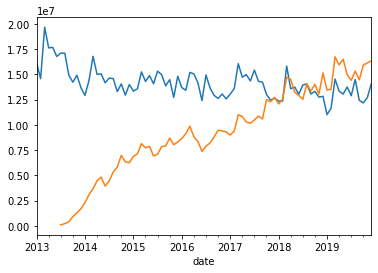

In [404]:
query("select * from casino where municipality = 'Elgin'").set_index('date').sort_index().loc['2013':'2019'].adjusted_gross_receipt.plot()
query("select * from video_gambling where municipality = 'Elgin'").set_index('date').groupby(pd.Grouper(freq='M')).sum().loc[:'2019'].amount_played.plot()

In [374]:
towns_with_casinos

,municipality
0,Alton
1,Elgin
2,Des Plaines
3,East Peoria
4,Rock Island
5,East St. Louis
6,Aurora
7,Metropolis
8,Joliet


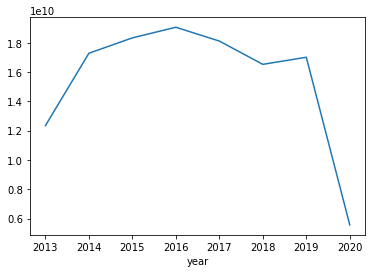

In [392]:
df[df.nearest_casino == '777 Jumer Dr, Rock Island, IL 61201'].set_index('year').agr.plot()

Let's collect the column descriptions from the `lookup` table and replace the variable names that are currently being used as column names. 

In [393]:
variable_map = lookup.drop('index', axis = 1).set_index('variable').to_dict('index')

def variable_rename(column):
    translator=str.maketrans('','',string.punctuation)
    if column  in variable_map:
        return variable_map[column]['description'].lower().strip().translate(translator).replace(' ', '_')
    else:
        return column

df.columns = [variable_rename(column) for column in df.columns]

In [365]:
def subplot_map(idx, columns):
    return (idx//columns, idx%columns)

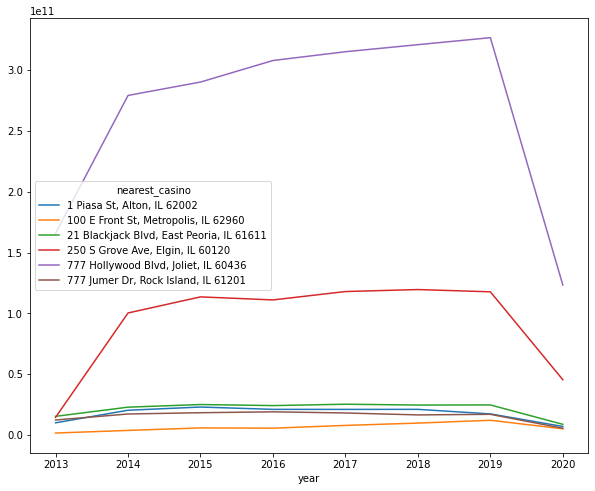

In [397]:

df[['agr', 'nearest_casino', 'year']]\
.reset_index()\
.pivot(index='year', columns = 'nearest_casino', values='agr')\
.plot(figsize=(10,8))

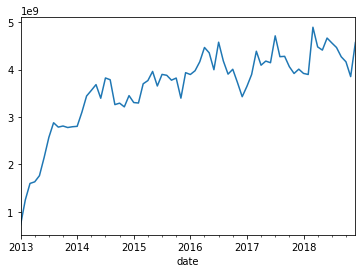

In [152]:
nearest_casino_groups[nearest_casino_groups.nearest_casino == nearest_casino_groups.nearest_casino.unique()[-1]]\
.set_index('date').loc['2012':].adjusted_gross_receipt.plot()

In [123]:
nearest_casino_groups['public_funds'] = nearest_casino_groups.casino_local_share + nearest_casino_groups.casino_state_share

In [124]:
model = sm.OLS(nearest_casino_groups.public_funds, nearest_casino_groups.amount_played).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           public_funds   R-squared (uncentered):                   0.669
Model:                            OLS   Adj. R-squared (uncentered):              0.668
Method:                 Least Squares   F-statistic:                              1161.
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                   4.36e-140
Time:                        18:10:59   Log-Likelihood:                         -13789.
No. Observations:                 576   AIC:                                  2.758e+04
Df Residuals:                     575   BIC:                                  2.758e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
amount_played    24.0832      0.707     34.074      0.000      22.695      25.471
==============================================================================
Omnibus:                      242.469   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              884.692
Skew:                           1.993   Prob(JB):                    7.79e-193
Kurtosis:                       7.580   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
df['amount_played_centered'] = df\
                                                .groupby("nearest_casino")["amount_played"]\
                                                .transform(lambda x: (x - x.mean())/x.std())


df['population_centered'] = df\
                                            .groupby('nearest_casino')['total_population_estimatetotal']\
                                            .transform(lambda x: (x-x.mean())/x.std())

                                                

In [318]:
model = sm.OLS(df.public_funds, df.amount_played_centered).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           public_funds   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              3.753
Date:                Mon, 21 Dec 2020   Prob (F-statistic):                      0.0532
Time:                        19:46:48   Log-Likelihood:                         -12719.
No. Observations:                 544   AIC:                                  2.544e+04
Df Residuals:                     543   BIC:                                  2.545e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
amount_played_centered  2.886e+08   1.49e+08      1.937      0.053   -4.02e+06    5.81e+08
==============================================================================
Omnibus:                      194.829   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              476.131
Skew:                           1.896   Prob(JB):                    4.07e-104
Kurtosis:                       5.574   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [319]:
df

,nearest_casino,agr,amount_played,terminal_count,video_local_share,video_state_share,casino_local_share,casino_state_share,total_agriculture_forestry_fishing_and_hunting_and_mining,total_construction,...,population_of_one_race_native_hawaiian_and_other_pacific_islander,population_of_one_race_some_other_race,median_age_total,educational_attainment_for_the_population_25_years_and_over,median_income_in_the_past_12_months_in_prior_year_inflationadjusted_dollarstotal_dollars,total_population_estimatetotal,amount_played_centered,population_centered,public_funds,public_funds_centered
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,"1 Piasa St, Alton, IL 62002",2.218860e+08,8003840.18,196.0,31248.56,156242.80,13734000.00,2.746800e+07,2160.0,22962.0,...,0.0,2430.0,1529.4,778056.0,936366.0,1148706.0,-2.366971,-3.376028,4.120200e+07,-2.483454
2013-01-02,"1 Piasa St, Alton, IL 62002",3.158793e+08,7691999.00,266.0,34649.30,173244.82,19446392.00,3.889278e+07,2880.0,30616.0,...,0.0,3240.0,2039.2,1037408.0,1248488.0,1531608.0,-2.378153,-3.240480,5.833918e+07,-2.343305
2013-01-03,"1 Piasa St, Alton, IL 62002",6.486013e+08,11060869.54,448.0,43140.30,215409.04,39454996.00,7.890999e+07,5040.0,53578.0,...,0.0,5670.0,3568.6,1815464.0,2184854.0,2680314.0,-2.257347,-2.833837,1.183650e+08,-1.852408
2013-01-04,"1 Piasa St, Alton, IL 62002",7.481353e+08,17053820.84,574.0,68645.78,343227.36,45526446.00,9.105289e+07,6480.0,68886.0,...,0.0,7290.0,4588.2,2334168.0,2809098.0,3446118.0,-2.042443,-2.562742,1.365793e+08,-1.703449
2013-01-05,"1 Piasa St, Alton, IL 62002",8.819993e+08,21219905.42,672.0,78166.06,390832.12,54320728.00,1.572308e+08,7920.0,84194.0,...,0.0,8910.0,5607.8,2852872.0,3433342.0,4211922.0,-1.893049,-2.291647,2.115515e+08,-1.090320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03,"777 Jumer Dr, Rock Island, IL 61201",5.986886e+08,29870229.62,1302.0,136070.06,761994.10,38506958.00,6.844153e+07,24054.0,221806.0,...,4066.0,278122.0,9693.8,6653534.0,6243210.0,10304498.0,-0.429850,0.755674,1.069485e+08,-2.025692
2020-01-07,"777 Jumer Dr, Rock Island, IL 61201",7.266681e+08,48410155.64,1288.0,230346.06,1336006.70,42843494.82,7.917689e+07,24054.0,221806.0,...,4066.0,278122.0,9693.8,6653534.0,6243210.0,10304498.0,0.946862,0.755674,1.220204e+08,-1.889944
2020-01-08,"777 Jumer Dr, Rock Island, IL 61201",7.547995e+08,49962060.54,1288.0,231628.18,1343442.94,46477546.92,8.421753e+07,24054.0,221806.0,...,4066.0,278122.0,9693.8,6653534.0,6243210.0,10304498.0,1.062101,0.755674,1.306951e+08,-1.811813


In [308]:
df['public_funds'] = df.casino_local_share + df.casino_state_share

df['public_funds_centered'] = df\
         .groupby('nearest_casino')['public_funds']\
                       .transform(lambda x: (x-x.mean())/x.std())

In [333]:
df = df.loc[:'2019']

In [338]:
model = sm.MixedLM.from_formula('agr ~ amount_played_centered', 
                        groups='nearest_casino',
                        re_formula = '1+amount_played_centered',
                        data=df)

results = model.fit()
results.summary()                                                

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Mixed Linear Model Regression Results
===============================================================================================================================
Model:                               MixedLM                    Dependent Variable:                    agr                     
No. Observations:                    502                        Method:                                REML                    
No. Groups:                          6                          Scale:                                 1636127275908422656.0000
Min. group size:                     82                         Log-Likelihood:                        -11224.9513             
Max. group size:                     84                         Converged:                             Yes                     
Mean group size:                     83.7                                                                                      
-------------------------------------------------------------------------------------------------------------------------------
                                                     Coef.               Std.Err.      z   P>|z|     [0.025          0.975]    
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                             6384495633.292  3739595356.388 1.707 0.088 -944976581.982 13713967848.565
amount_played_centered                                1219432907.451   677629851.834 1.800 0.072 -108697196.992  2547563011.894
nearest_casino Var                          83887766999549820928.000 41697878223.548                                           
nearest_casino x amount_played_centered Cov 14953070992733655040.000  7492916200.638                                           
amount_played_centered Var                   2734358188050298880.000  1368871789.439                                           
===============================================================================================================================

"""

In [77]:
4312377432153.549/np.sqrt(101913621706686.797*242663498190.645)

0.867158369065354

In [102]:
magnitude(101727957492842.625)

14263797.355041372

In [78]:
nearest_casino_groups.amount_played_centered

0     -2.095859
1     -1.966740
2     -1.778719
3     -1.743339
4     -1.639367
         ...   
571    1.291566
572    1.172321
573    1.381183
574    1.255516
575    1.477144
Name: amount_played_centered, Length: 576, dtype: float64

In [67]:
results.random_effects

{'1 Piasa St, Alton, IL 62002': nearest_casino   -7.487170e+06
 dtype: float64,
 '100 E Front St, Metropolis, IL 62960': nearest_casino   -4.660161e+06
 dtype: float64,
 '200 S Front St, East St Louis, IL 62201': nearest_casino   -2.925257e+06
 dtype: float64,
 '21 Blackjack Blvd, East Peoria, IL 61611': nearest_casino   -4.578036e+06
 dtype: float64,
 '250 S Grove Ave, Elgin, IL 60120': nearest_casino    2.390582e+06
 dtype: float64,
 '3000 S River Rd, Des Plaines, IL 60018': nearest_casino    2.380037e+07
 dtype: float64,
 '777 Hollywood Blvd, Joliet, IL 60436': nearest_casino   -857820.758661
 dtype: float64,
 '777 Jumer Dr, Rock Island, IL 61201': nearest_casino   -5.682508e+06
 dtype: float64}

In [31]:
industry_variables = ['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations']

In [33]:
table = nearest_casino_groups[industry_variables].div(nearest_casino_groups.total_population_estimatetotal, axis=0)
largest_industry = []
for idx in table.index:
    industry = table.loc[idx][industry_variables].sort_values(ascending=False).index[0]
    largest_industry.append(industry)

In [35]:
len(largest_industry)

576

In [37]:
nearest_casino_groups['largest_industry'] = largest_industry

In [40]:
top_three_industries = list(set(largest_industry))

In [43]:
nearest_casino_groups.columns

Index(['nearest_casino', 'date',
       'total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_materi

In [48]:
top_three_industries

['total_sales_and_office_occupations',
 'total_management_business_science_and_arts_occupations',
 'total_educational_services_and_health_care_and_social_assistance']

In [50]:
nearest_casino_groups[nearest_casino_groups.largest_industry==top_three_industries[0]].total_population_estimatetotal.mean()

20993327.083333332

In [51]:
nearest_casino_groups[nearest_casino_groups.largest_industry==top_three_industries[1]].total_population_estimatetotal.mean()

35051572.96577947

In [52]:
nearest_casino_groups[nearest_casino_groups.largest_industry==top_three_industries[2]].total_population_estimatetotal.mean()

5216653.230769231

In [66]:
nearest_casino_groups

576

**TO DO**

Take the dataframe above and see if you can cluster these observations according to industry representation. 

In [252]:
casino_dataframe['amount_played_centered'] = casino_dataframe\
                                                .groupby("nearest_casino")["amount_played"]\
                                                .transform(lambda x: (x - x.mean())/x.std())

casino_dataframe['population_centered'] = casino_dataframe\
                                            .groupby('nearest_casino')['total_population_estimatetotal']\
                                            .transform(lambda x: (x-x.mean())/x.std())
                                                

model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered',
                        re_formula='1',
                        groups='nearest_casino',
                        data=casino_dataframe)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                     MixedLM         Dependent Variable:         adjusted_gross_receipt
No. Observations:          575             Method:                     REML                  
No. Groups:                8               Scale:                      1911020226108.7695    
Min. group size:           71              Log-Likelihood:             -8950.1214            
Max. group size:           72              Converged:                  Yes                   
Mean group size:           71.9                                                              
---------------------------------------------------------------------------------------------
                              Coef.          Std.Err.     z    P>|z|    [0.025      0.975]   
---------------------------------------------------------------------------------------------
Intercept                     11888781.657  3572607.040  3.328 0.001 4886600.527 18890962.787
amount_played_centered         -449165.228    58055.198 -7.737 0.000 -562951.325  -335379.130
nearest_casino Var     102081579834167.859 39684636.969                                      
=============================================================================================

"""

In [62]:
def magnitude(coefficient):
    return np.sqrt(2*coefficient)

In [63]:
magnitude(results.cov_re.iloc[0].values[0])

14263797.355041372

In [80]:
np.sqrt(0.004)

0.06324555320336758

# Can I get the autoregressive model working? Can I somehow factor for time? 

In [236]:
casino_dataframe_autoregressive = casino_dataframe[casino_dataframe.date >= '2014']
casino_dataframe_autoregressive.set_index('date', inplace=True)

In [238]:
type(casino_dataframe_autoregressive.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [247]:
# model_autoregressive = sm.GEE().from_formula(
#     formula = "adjusted_gross_receipt ~ amount_played_centered",
#     groups="nearest_casino",
#     cov_struct=sm.cov_struct.Autoregressive(),
#     data=casino_dataframe_autoregressive
#     ).fit()

X = casino_dataframe_autoregressive.amount_played_centered
y = casino_dataframe_autoregressive.adjusted_gross_receipt
X = sm.add_constant(X)
model_autoregressive = sm.GEE(y,X,
                            groups=casino_dataframe_autoregressive.nearest_casino, times=casino_dataframe_autoregressive.index,
                            cov_struct=sm.cov_struct.Autoregressive())

model_autoregressive = model_autoregressive.fit()
model_autoregressive.summary()

ValueError: Autoregressive: unable to find right bracket

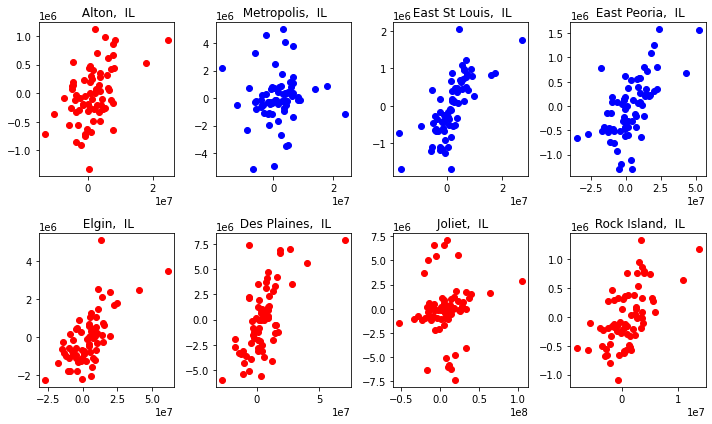

In [46]:
shape = (2,4)
fig, axes = plt.subplots(*shape, figsize=(10,6))

for idx in range(len(casinos)):
    row, column = subplot_map(idx, shape[1])
    casino  = casinos[idx]
    dataframe = differences[differences.casino == casino]
    x = dataframe.amount_played
    y = dataframe.adjusted_gross_receipt
    axes[row, column].scatter(x,y, color='red' if list(y)[-1] > list(y)[0] else 'blue')
    title = casino.split(',')
    title = title[1] + ', ' + title[2][:3]
    axes[row, column].set_title(title)
fig.tight_layout()

In [39]:
vc = {'amount_played_centered': '0 + amount_played_centered'}
model = sm.MixedLM.from_formula('adjusted_gross_receipt ~ amount_played_centered', 
                        vc_formula=vc,
                        groups='casino',
                        data=differences)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
===========================================================================================
Model:                     MixedLM        Dependent Variable:        adjusted_gross_receipt
No. Observations:          567            Method:                    REML                  
No. Groups:                8              Scale:                     2430229783450.1279    
Min. group size:           70             Log-Likelihood:            -8873.3157            
Max. group size:           71             Converged:                 Yes                   
Mean group size:           70.9                                                            
-------------------------------------------------------------------------------------------
                                Coef.        Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------------------------
Intercept                        -19135.295  65468.462 -0.292 0.770 -147451.123  109180.534
amount_played_centered           596838.670 227286.787  2.626 0.009  151364.752 1042312.587
amount_played_centered Var 378493874023.188 142606.711                                     
===========================================================================================

"""

In [41]:
model_autoregressive = sm.GEE.from_formula(
    formula = "adjusted_gross_receipt ~ amount_played_centered",
    groups="casino",
    cov_struct=sm.cov_struct.Autoregressive(), 
    data=differences
    ).fit()

model_autoregressive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                GEE Regression Results                               
=====================================================================================
Dep. Variable:        adjusted_gross_receipt   No. Observations:                  567
Model:                                   GEE   No. clusters:                        8
Method:                          Generalized   Min. cluster size:                  70
                        Estimating Equations   Max. cluster size:                  71
Family:                             Gaussian   Mean cluster size:                70.9
Dependence structure:         Autoregressive   Num. iterations:                     2
Date:                       Sat, 31 Oct 2020   Scale:               2758338938291.368
Covariance type:                      robust   Time:                         17:20:25
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.914e+04   1.67e+04     -1.147      0.252   -5.18e+04    1.36e+04
amount_played_centered  5.969e+05   2.13e+05      2.803      0.005     1.8e+05    1.01e+06
==============================================================================
Skew:                          0.3777   Kurtosis:                       6.2037
Centered skew:                 0.3534   Centered kurtosis:              6.1352
==============================================================================
"""

In [ ]:
172,485,344,229
596,900

In [183]:
algo = OLS(differences.adjusted_gross_receipt, differences.amount_played)

In [184]:
model = algo.fit()

In [185]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     adjusted_gross_receipt   R-squared (uncentered):                   0.146
Model:                                OLS   Adj. R-squared (uncentered):              0.145
Method:                     Least Squares   F-statistic:                              97.04
Date:                    Mon, 26 Oct 2020   Prob (F-statistic):                    3.08e-21
Time:                            22:40:31   Log-Likelihood:                         -8907.7
No. Observations:                     567   AIC:                                  1.782e+04
Df Residuals:                         566   BIC:                                  1.782e+04
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
amount_played     0.0530      0.005      9.851      0.000       0.042       0.064
==============================================================================
Omnibus:                       86.597   Durbin-Watson:                   3.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.645
Skew:                          -0.051   Prob(JB):                    7.17e-229
Kurtosis:                       9.668   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

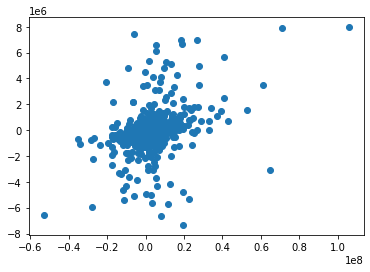

In [186]:
plt.scatter(differences.amount_played, differences.adjusted_gross_receipt)

In [187]:
from sklearn.linear_model import LinearRegression

In [188]:
model = LinearRegression()
model.fit(differences.amount_played.to_numpy().reshape(-1,1), differences.adjusted_gross_receipt.to_numpy().reshape(-1,1))

LinearRegression()

In [189]:
preds = model.predict(differences.amount_played.to_numpy().reshape(-1,1))

In [190]:
from sklearn.metrics import r2_score

In [191]:
r2_score(differences.adjusted_gross_receipt.to_numpy().reshape(-1,1), preds)

0.15584202108358425

In [208]:
monthly_terminal_count = df[['name', 'terminal_count', 'total_population_estimatetotal']].groupby(['name', pd.Grouper(freq='MS')]).sum().reset_index()
monthly_terminal_count[monthly_terminal_count.terminal_count > 100].name.value_counts()

Joliet         72
Rockford       71
Springfield    70
Bloomington    69
Kankakee       67
               ..
Oswego          4
Marion          4
East Moline     3
Sandwich        2
Metropolis      1
Name: name, Length: 91, dtype: int64

In [202]:
monthly_terminal_count[monthly_terminal_count.terminal_count < 50]

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[47629 rows x 1 columns]

In [193]:
df[['name', 'terminal_count']].groupby(['name', pd.Grouper(freq='MS')]).sum()

terminal_count
name     date                      
Abingdon 2013-01-01            10.0
         2013-02-01            14.0
         2013-03-01            14.0
         2013-04-01            14.0
         2013-05-01            17.0
...                             ...
Zion     2018-08-01            35.0
         2018-09-01            35.0
         2018-10-01            35.0
         2018-11-01            35.0
         2018-12-01            35.0

[57353 rows x 1 columns]

In [194]:
df.columns

Index(['total_agriculture_forestry_fishing_and_hunting_and_mining',
       'total_construction', 'total_manufacturing', 'total_wholesale_trade',
       'total_retail_trade',
       'total_transportation_and_warehousing_and_utilities',
       'total_information',
       'total_finance_and_insurance_and_real_estate_and_rental_and_leasing',
       'total_professional_scientific_and_management_and_administrative_and_waste_management_services',
       'total_educational_services_and_health_care_and_social_assistance',
       'total_arts_entertainment_and_recreation_and_accommodation_and_food_services',
       'total_other_services_except_public_administration',
       'total_public_administration',
       'total_management_business_science_and_arts_occupations',
       'total_service_occupations', 'total_sales_and_office_occupations',
       'total_natural_resources_construction_and_maintenance_occupations',
       'total_production_transportation_and_material_moving_occupations',
       'p